# AutoEncoder를 사용한 이상탐지

정상인 데이터들 중에 소수의 비정상인 데이터가 포함되어 있다.

AutoEncoder를 사용하여 학습 시킨다.

이렇게 학습된 AutoEncoder는 대부분의 정상 데이터에 대하여 복원 능력이 있다. 하지만 소수의 비정상 데이터에 대해서는 제대로 복원하지 못한다.

이렇게 학습시킨 AutoEncoder를 가지고 특정 영상을 복원 하게 하고 그 복원 결과가 좋지 않을 경우 정상영상이 아니라고 판정한다.

originality from https://www.pyimagesearch.com/2020/03/02/anomaly-detection-with-keras-tensorflow-and-deep-learning/

In [1]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import numpy as np

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

import random
import pickle
import cv2
import matplotlib


# 데이터 준비

## 데이터 로딩

In [2]:
((trainX, trainY), (testX, testY)) = mnist.load_data()

## 데이터셋 생성

1의 레이블 영상이 정상이고 3의 레이블 영상이 비정상으로 한다.

정상 영상과 비정상 영상의 비율을 100:1로 해서 골라내고, 골고루 섞은 데이터셋을 만든다.



In [3]:
def build_unsupervised_dataset(data, labels, validLabel=1, anomalyLabel=3, contam=0.01, seed=42):

  # 레이블 1인 영상의 인덱스
	validIdxs = np.where(labels == validLabel)[0]
  # 레이블 3인 영상의 인덱스
	anomalyIdxs = np.where(labels == anomalyLabel)[0]

  # 무작위로 섞어 주고
	random.shuffle(validIdxs)
	random.shuffle(anomalyIdxs)

  # 비정상 데이터의 갯수를 비정상 데이터 갯수 대비 0.01(contam)로 한다.
	i = int(len(validIdxs) * contam)
	anomalyIdxs = anomalyIdxs[:i]

	print("len(validIdx)=",len(validIdxs))
	print("len(anomalyIdxs)=",len(anomalyIdxs))

  # 추려낸 정상 데이터와 비정상 제이터
	validImages = data[validIdxs]
	anomalyImages = data[anomalyIdxs]

  # 두개의 데이터를 합하고, 다시 섞어주고
	images = np.vstack([validImages, anomalyImages])   # 두 배열을 위에서 아래로 붙이기
 #>>>  a = np.array([1, 2, 3])
 #>>>  b = np.array([4, 5, 6])
 #>>>  np.vstack([a, b])

# array([[1, 2, 3],
#       [4, 5, 6]])

	np.random.seed(seed)   # seed값을 설정하면 섞을 때마다 랜덤값이 동일
	np.random.shuffle(images)

	return images

images = build_unsupervised_dataset(trainX, trainY, validLabel=1, anomalyLabel=3, contam=0.01)

len(validIdx)= 6742
len(anomalyIdxs)= 67


In [4]:
print(images.shape)
print(np.max(images))
print(np.min(images))

(6809, 28, 28)
255
0


## 데이터 모양 변경, Normalization

Conv2D 사용을 위해 데이터 모양을 (H, W, channel)의 3차원으로 만들고
(28, 28) -> (28, 28, 1)

0 ~ 1.0으로 normlaization 한다.



In [5]:
images = np.expand_dims(images, axis=-1)
images = images.astype("float32") / 255.0

In [6]:
print(images.shape)
print(np.max(images))
print(np.min(images))

(6809, 28, 28, 1)
1.0
0.0


## 데이터 분리

In [7]:
(trainX, testX) = train_test_split(images, test_size=0.2, random_state=42)

In [8]:
print(trainX.shape)
print(testX.shape)

(5447, 28, 28, 1)
(1362, 28, 28, 1)


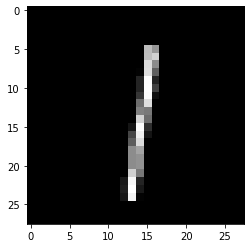

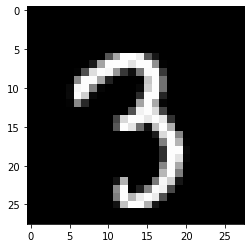

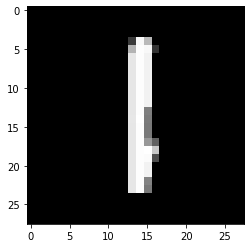

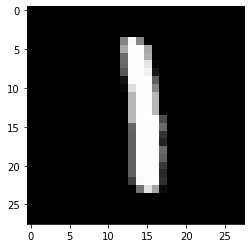

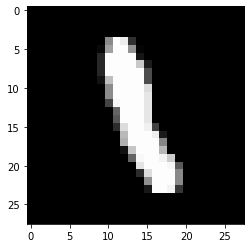

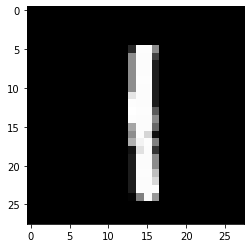

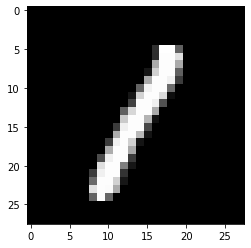

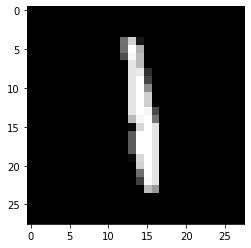

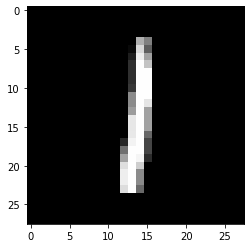

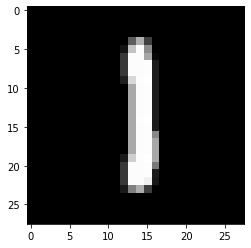

In [14]:
for i in range(10):
  plt.imshow(trainX[i].reshape((28,28)))
#   plt.gray()
  plt.show()

# 학습

## 모델 정의

In [10]:
# Functional API
class ConvAutoencoder:

	@staticmethod
	def build(width, height, depth, filters=(32, 64), latentDim=16):
		inputShape = (height, width, depth)
		chanDim = -1

		inputs = Input(shape=inputShape)
		x = inputs

		for f in filters:
			# apply a CONV => RELU => BN operation
			x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization(axis=chanDim)(x)

		volumeSize = K.int_shape(x)
		x = Flatten()(x)
		latent = Dense(latentDim)(x)

		encoder = Model(inputs, latent, name="encoder")




		latentInputs = Input(shape=(latentDim,))
		x = Dense(np.prod(volumeSize[1:]))(latentInputs)
		x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)

		for f in filters[::-1]:
			# apply a CONV_TRANSPOSE => RELU => BN operation
			x = Conv2DTranspose(f, (3, 3), strides=2, padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization(axis=chanDim)(x)

		x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
		outputs = Activation("sigmoid")(x)

		decoder = Model(latentInputs, outputs, name="decoder")



		autoencoder = Model(inputs, decoder(encoder(inputs)), name="autoencoder")


		return autoencoder

## 모델 생성

In [11]:
autoencoder = ConvAutoencoder.build(28, 28, 1)
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Functional)         (None, 16)                69392     
_________________________________________________________________
decoder (Functional)         (None, 28, 28, 1)         109377    
Total params: 178,769
Trainable params: 178,385
Non-trainable params: 384
_________________________________________________________________


## 모델 컴파일

In [12]:
# decay값은 1 step 마다 감소하는 비율
opt = Adam(lr=1e-3, decay=0.0025)
autoencoder.compile(loss="mse", optimizer=opt)

C:\Users\JuNoe\anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


## 학습

In [13]:
history = autoencoder.fit(trainX, trainX, validation_split=0.1, epochs=20, batch_size=32)

Epoch 1/20
154/154 [==============================] - 4s 10ms/step - loss: 0.0504 - val_loss: 0.0413
Epoch 2/20
154/154 [==============================] - 1s 7ms/step - loss: 0.0164 - val_loss: 0.0371
Epoch 3/20
154/154 [==============================] - 1s 8ms/step - loss: 0.0094 - val_loss: 0.0168
Epoch 4/20
154/154 [==============================] - 1s 7ms/step - loss: 0.0046 - val_loss: 0.0047
Epoch 5/20
154/154 [==============================] - 1s 7ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 6/20
154/154 [==============================] - 1s 7ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 7/20
154/154 [==============================] - ETA: 0s - loss: 0.002 - 1s 7ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 8/20
154/154 [==============================] - 1s 7ms/step - loss: 0.0027 - val_loss: 0.0029
Epoch 9/20
154/154 [==============================] - 1s 7ms/step - loss: 0.0026 - val_loss: 0.0029
Epoch 10/20
154/154 [==============================] - 1s 7ms/step - loss: 

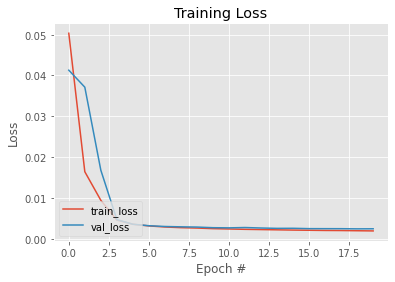

In [14]:
N = np.arange(len(history.history['loss']))

plt.style.use("ggplot")
plt.figure()
plt.plot(N, history.history["loss"], label="train_loss")
plt.plot(N, history.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

## 테스트 데이터에 대한 복원 실행

In [15]:
reconstructed = autoencoder.predict(testX)

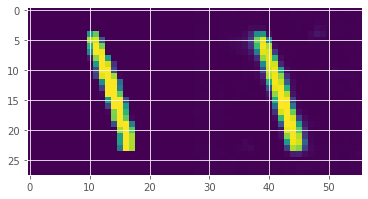

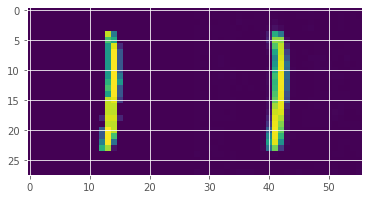

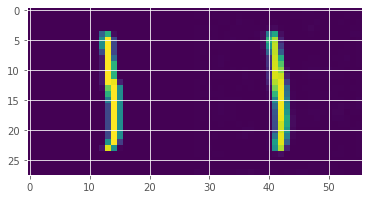

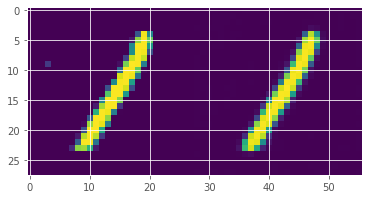

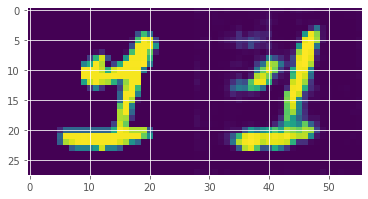

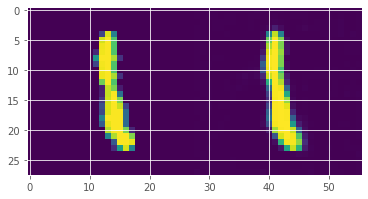

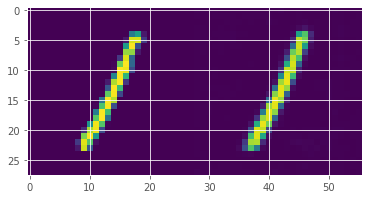

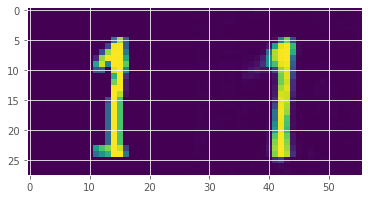

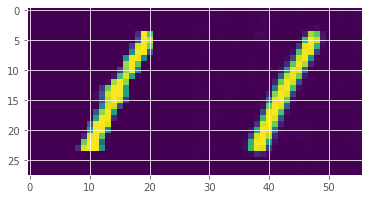

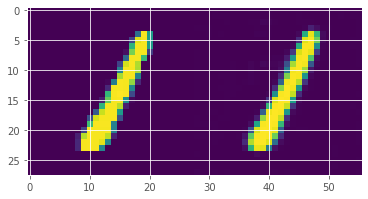

In [16]:
for i in range(10):
  combined = np.hstack([testX[i], reconstructed[i]])
  plt.imshow(combined.squeeze())
  plt.show()

# 이상 탐지

학습된 AutoEncoder는 1 영상(정상 영상)의 경우 잘 복원한다. 그러나 그렇지 않은 경우 잘 복원하지 못한다.


1의 영상은 정상이고, 3의 영상은 비정상이다.

또한 1이외의 정상 역시 비정상이다.

<br>

AutoEncoder를 사용하여 인코딩과 디코딩을 통해 복원하고, 복원된 것이 원본과 차이가 날 수록 비정상인것으로 판단한다.

## 복원 실행

In [17]:
reconstructed = autoencoder.predict(testX)

## 차이 계산

In [18]:
errors = []

for (image, recon) in zip(testX, reconstructed):
	# compute the mean squared error between the ground-truth image
	# and the reconstructed image, then add it to our list of errors
	mse = np.mean((image - recon) ** 2)
	errors.append(mse)

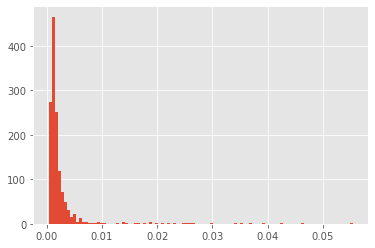

In [19]:
plt.hist(errors, bins=100)
plt.show()

데이터의 1/101이 비정상 데이터이다.

quantile 0.99 이상이 되는 threshold를 구하자.

In [20]:
threshold = np.quantile(errors, 0.99)
print(threshold)

0.023847138863057032


In [21]:
anomaly_idxs = np.where(np.array(errors) >= threshold)[0]
print(len(anomaly_idxs))

14


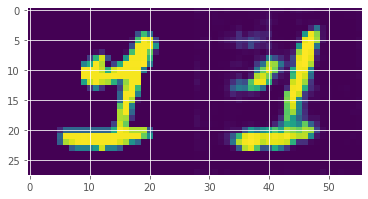

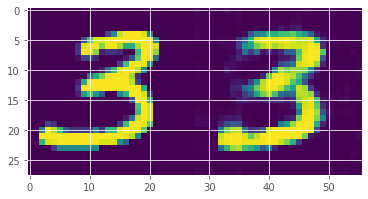

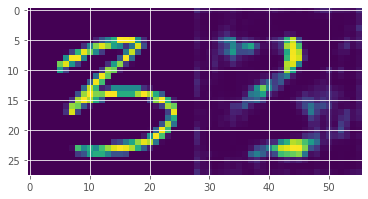

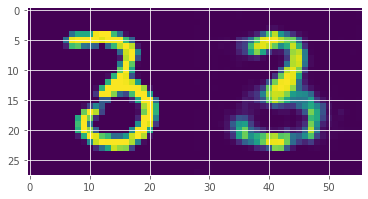

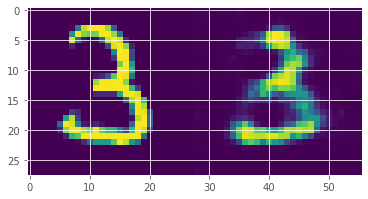

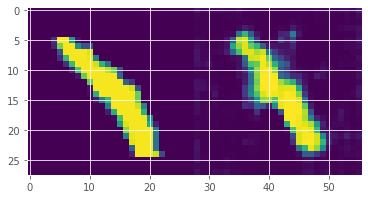

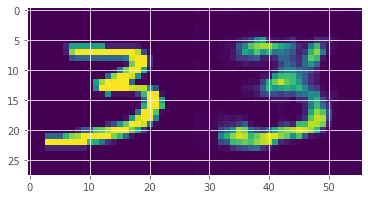

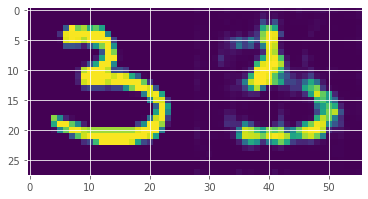

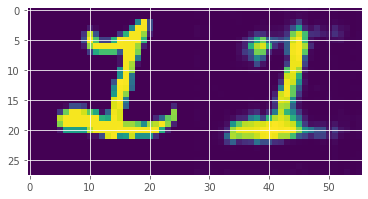

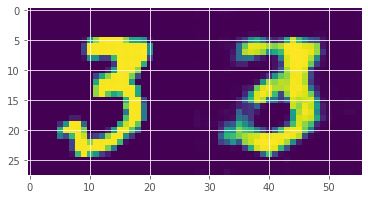

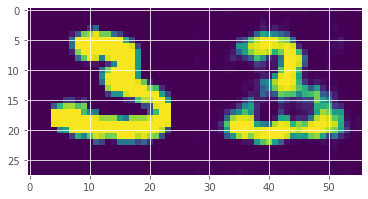

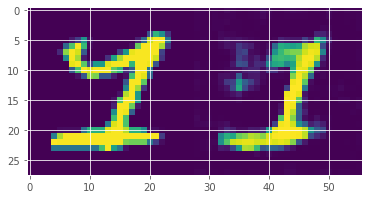

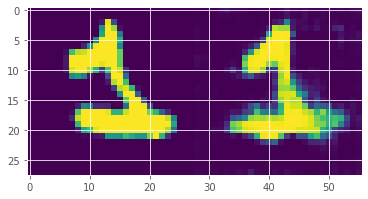

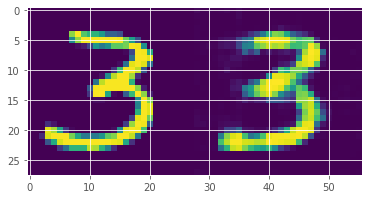

In [22]:
for i in anomaly_idxs:
  combined = np.hstack([testX[i], reconstructed[i]])
  plt.imshow(combined.squeeze())
  plt.show()

비정상 영상인 3자와, 정말 이상하게 생긴 1자를 잘 찾아 냈다.

# 1과 3 이외의 입력

In [23]:
((trainX, trainY), (testX, testY)) = mnist.load_data()

In [24]:
testX = np.expand_dims(testX, axis=-1)
testX = testX.astype("float32") / 255.0

In [25]:
print(testX.shape)
print(reconstructed.shape)

(10000, 28, 28, 1)
(1362, 28, 28, 1)


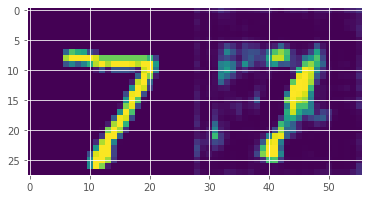

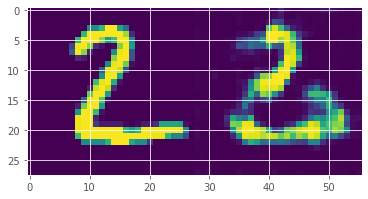

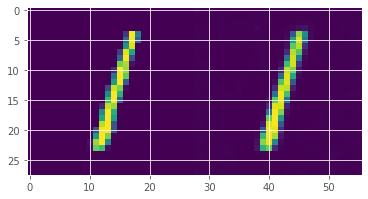

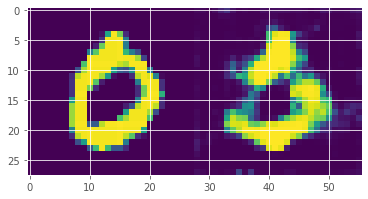

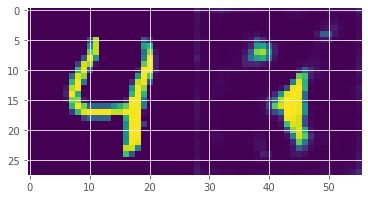

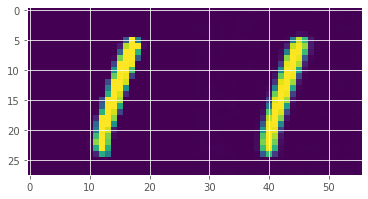

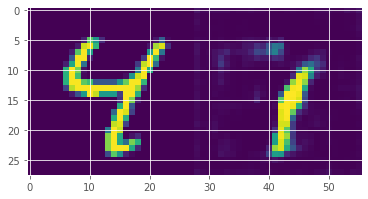

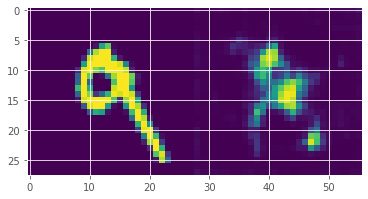

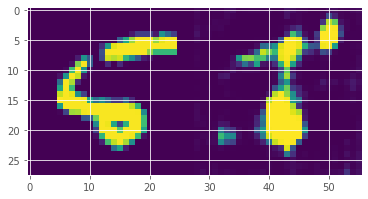

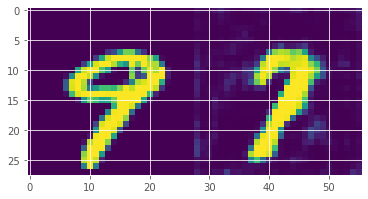

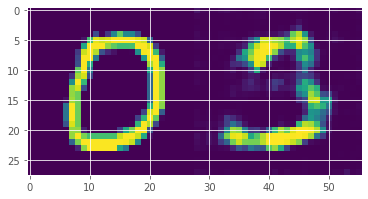

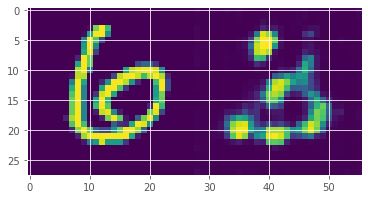

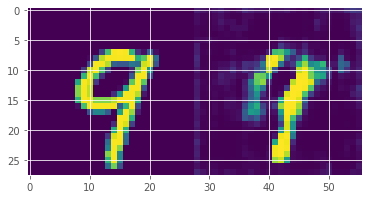

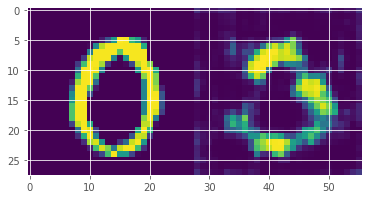

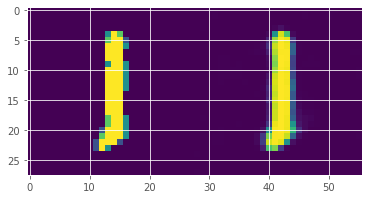

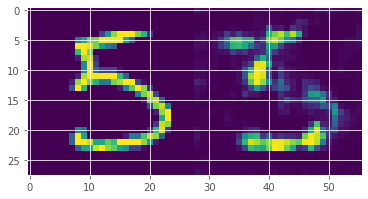

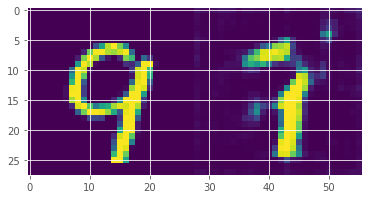

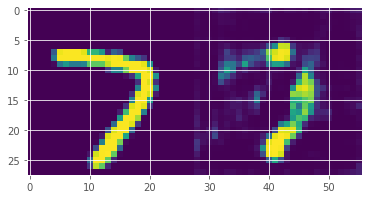

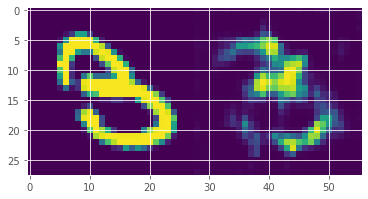

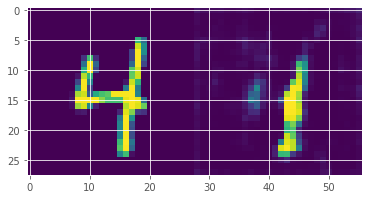

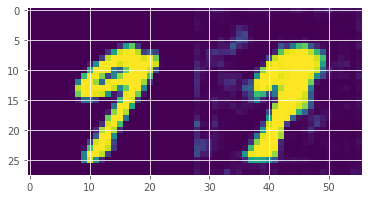

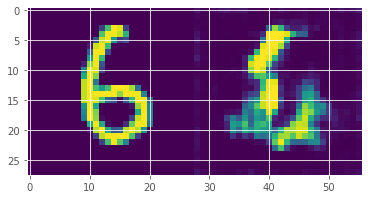

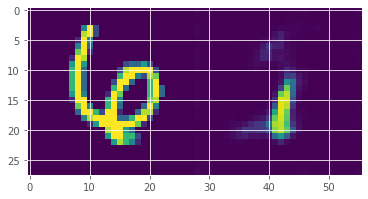

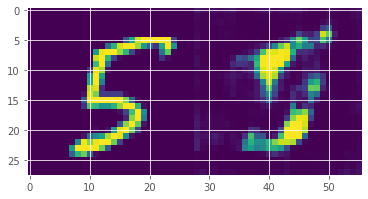

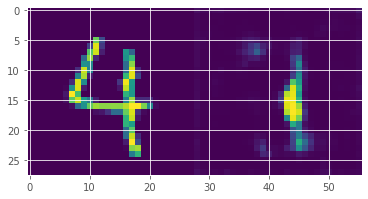

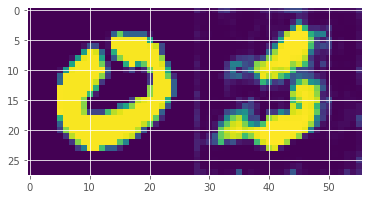

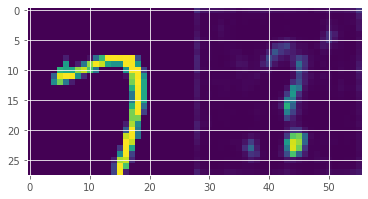

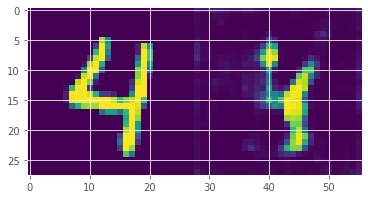

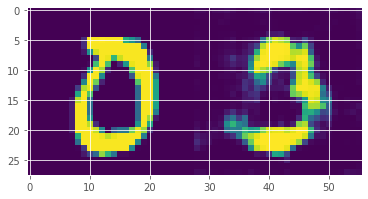

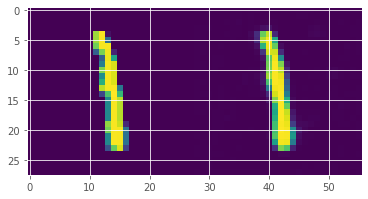

In [26]:
reconstructed = autoencoder.predict(testX)

for i in range(30):
  combined = np.hstack([testX[i], reconstructed[i]])
  plt.imshow(combined.squeeze())
  plt.show()

